# 3) Portfolio Construction & Risk Control

> Read me
- Run top-to-bottom. Uses simulated data only (numpy/pandas/matplotlib).
- Cells with **TODO** are what interviewers often expect you to implement.
- Keep runs fast. Vectorize when possible.
- Use clean functions with docstrings; add comments where you make assumptions.


## Setup & Data (simulated)

In [ ]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

np.random.seed(123)
n = 600
sectors = 10
months = pd.period_range('2014-01','2020-12',freq='M').to_timestamp('M')
tickers = [f"U{i:04d}" for i in range(n)]
sector = pd.Series(np.random.randint(0,sectors,size=n), index=tickers)
beta = pd.Series(np.clip(np.random.normal(1.0,0.25,n),0.2,2.0), index=tickers)

mi = pd.MultiIndex.from_product([months, tickers], names=["date","ticker"])
df = pd.DataFrame(index=mi)

sig_true = pd.DataFrame({
    "value": np.random.normal(0,1,len(df)),
    "quality": np.random.normal(0,1,len(df)),
    "momentum": np.random.normal(0,1,len(df))
}, index=df.index)

theta = np.array([0.0025, 0.002, 0.003])
mkt = pd.Series(np.random.normal(0.004,0.03,len(months)), index=months)

df["beta"] = beta.loc[df.index.get_level_values("ticker")].values
df["sector"] = sector.loc[df.index.get_level_values("ticker")].values
df[["value","quality","momentum"]] = sig_true.values

# fix buggy code for getting sec shocks
sec_cols = [f"s{i}" for i in range(sectors)]
sec_shocks = pd.DataFrame(np.random.normal(0,0.015,(len(months),sectors)), index=months, columns=sec_cols)
# sec_val = sec_shocks.stack()
# sec_val.index = pd.MultiIndex.from_tuples([(t, int(c[1:])) for (t,c) in sec_val.index])

date_idx = sec_shocks.index.get_indexer(df.index.get_level_values("date"))
sec_idx  = df["sector"].to_numpy()
sec_val = sec_shocks.to_numpy()[date_idx, sec_idx]

df["ret"] = (mkt.loc[df.index.get_level_values(0)].values * df["beta"].values
             + 0.002*sec_val
             + sig_true.values @ theta
             + np.random.normal(0,0.05,len(df)))

def zscore(g): 
    return (g - g.mean())/g.std(ddof=0)

panel = df.copy()
for c in ["value","quality","momentum"]:
    panel[c] = panel.groupby("date")[c].transform(zscore)
panel["score"] = 0.4*panel["momentum"] + 0.3*panel["quality"] + 0.3*panel["value"]


## TODO Checklist
1. Construct starting weights from **score** and ensure **dollar neutrality**.
2. **Project to sector-neutral and beta-neutral** (iterative adjustment is fine).
3. Enforce **position cap** (e.g., 1%) and **turnover limit** (≤ 15%/mo) by scaling.
4. Add a **transaction cost model** (e.g., 30 bps per 100% turnover).
5. Compare against **equal-weight** and **risk-parity** baselines on IR after costs.


In [112]:
dates = panel.index.get_level_values(0).unique().sort_values()
tickers = panel.index.get_level_values(1).unique()
prev_w = pd.Series(0, index=tickers)
max_abs = 0.01
turnover_cap = 0.15
tc_per_turnover = 0.003

def project_neutral(w, beta, sector):
    # TODO: iteratively adjust for sector and beta neutrality
    for _ in range(5):
        # sector neutral
        sec_g = w.groupby(sector).sum()
        adj = pd.Series(0, index=w.index)
        for s, val in sec_g.items():
            names = sector[sector==s].index
            if len(names):
                adj.loc[names] -= val/len(names)
        w += adj
        # beta neutral
        b = (beta*w).sum()
        w -= (b * beta / (beta**2).sum())
        # dollar neutral
        w -= w.mean()
    return w

def risk_parity_weights(vol):
    # TODO: inverse-vol weights normalized to dollar neutral
    inv = 1/vol.replace(0, np.nan)
    inv = inv.fillna(inv.median())
    w = inv / inv.abs().sum()
    w -= w.mean()
    if np.all(np.isnan(w)): return pd.Series(0, index=vol.index)
    return w

In [60]:
vol = panel['ret'].unstack(-1).rolling(5, min_periods=1).std().fillna(0).stack()

In [ ]:
results = []
eq_results = []
rp_results = []
prev_eq = prev_w.copy()
prev_rp = prev_w.copy()


for d in dates:
    snap = panel.loc[d]
    # 1) start weights from score
    score = snap.score
    w = score / score.abs().sum()
    w -= w.mean()
    # 2) project neutrality
    w = project_neutral(w, beta, sector)
    w = w.clip(-max_abs, max_abs)
    w -= w.mean()
    # 3) cap and turnover limit
    to = (w - prev_w).abs().sum()
    if to > turnover_cap:
        scale = turnover_cap / to
        w = prev_w + (w-prev_w) * scale
        to = turnover_cap
    # 4) apply TC and record results
    r = (snap.ret * w).sum() - tc_per_turnover * to
    results.append({"date": d, "ret": r, "turnover": to})
    prev_w = w

    # TODO 5: build equal-weight and risk-parity baselines and compare IRs after costs
    # equal weight baseline
    names = score.abs().nlargest(100).index
    w_eq = pd.Series(0, index=tickers)
    w_eq.loc[names[:50]] = 1/100
    w_eq.loc[names[-50:]] = -1/100
    w_eq = project_neutral(w_eq, beta, sector).clip(-max_abs, max_abs)
    w_eq -= w_eq.mean()
    to_eq = (w_eq - prev_eq).abs().sum()
    r_eq = (snap.ret * w_eq).sum() - tc_per_turnover * to_eq
    eq_results.append({"date": d, "ret": r_eq, 'turnover': to_eq})
    prev_eq = w_eq

    # risk parity baseline
    
    vol_snap = vol.loc[d]
    w_rp = risk_parity_weights(vol_snap)
    w_rp = project_neutral(w_rp, beta, sector).clip(-max_abs, max_abs)
    w_rp -= w_rp.mean()
    to_rp = (w_rp - prev_rp).abs().sum()
    r_rp = (snap.ret * w_rp).sum() - tc_per_turnover * to_rp
    rp_results.append({"date": d, "ret": r_rp, 'turnover': to_rp})
    prev_rp = w_rp
    

res = pd.DataFrame(results).set_index("date")
eq = pd.DataFrame(eq_results).set_index("date")
rp = pd.DataFrame(rp_results).set_index("date")

def IR(x): 
    m, s = x.mean(), x.std(ddof=0)
    return m/s if s!=0 else np.nan

print("IR (optimized):", IR(res["ret"]))
print("IR (equal-weight):", IR(eq["ret"]))
print("IR (risk parity):", IR(rp["ret"]))
    

IR (optimized): 0.5275288926606432
IR (equal-weight): -1.1941257881519378
IR (risk parity): -0.2005129737725754


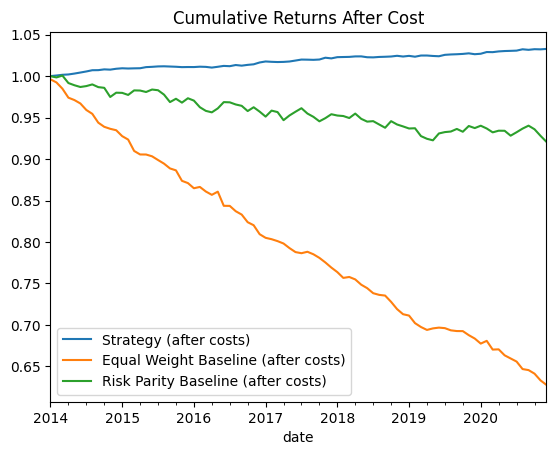

In [128]:
import matplotlib.pyplot as plt
plt.figure()
(1+res["ret"]).cumprod().plot(label="Strategy (after costs)")
(1+eq["ret"]).cumprod().plot(label="Equal Weight Baseline (after costs)")
(1+rp["ret"]).cumprod().plot(label="Risk Parity Baseline (after costs)")
plt.legend()
plt.title('Cumulative Returns After Cost')
plt.show()